In [1]:
%pip install pandas
%pip install scikit-learn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch

metadata_df = pd.read_csv("./data/sort.csv")
image_tensor = torch.load("./data/loaded_images_tensor.pt")

assert len(metadata_df) == image_tensor.size(0), "数据大小不匹配"
# image_tensor.shape

/tmp/ipykernel_7784/338700035.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensor = torch.load("./data/loaded_images_tensor.pt")


In [3]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
metadata_df[['age_approx', 'clin_size_long_diam_mm']] = scaler.fit_transform(metadata_df[['age_approx', 'clin_size_long_diam_mm']])
# print(metadata_df)

eva_data = metadata_df.drop(columns = ['id', 'isic_id'])

# X_metadata =  metadata_df.drop(columns = ['is_melanoma','isic_id'])
X_metadata =  metadata_df
y = metadata_df['is_melanoma']

X_train_meta_V, X_test_meta_V, y_train, y_test = train_test_split(X_metadata, y, test_size=0.2, random_state=42)

X_train_meta = X_train_meta_V.drop(columns = ['is_melanoma','isic_id'])
X_test_meta = X_test_meta_V.drop(columns = ['is_melanoma','isic_id'])

image_ids = X_train_meta['id'].values
X_train_meta_tensor = image_tensor[image_ids]
X_train_meta =  X_train_meta.drop(columns = ['id'])

image_ids_test = X_test_meta['id'].values
X_test_meta_tensor = image_tensor[image_ids_test]
X_test_meta =  X_test_meta.drop(columns = ['id'])
# X_train_meta_tensor.shape

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# X_train_meta_tensor

In [5]:
print(X_train_meta_tensor.shape) 
print(y_train.shape)
y_train = torch.tensor(y_train.values)
y_test = torch.tensor(y_test.values)
# X_train_meta_tensor
# y_train

torch.Size([3779, 3, 224, 224])
(3779,)


In [6]:

train_dataset = TensorDataset(X_train_meta_tensor, y_train)
test_dataset = TensorDataset(X_test_meta_tensor, y_test)

In [7]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)  
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)  
        self.fc1 = nn.Linear(64 * 56 * 56, 128)  
        self.fc2 = nn.Linear(128, 1)  

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  
        # print(f'After conv1 and pool: {x.shape}')
        x = self.pool(F.relu(self.conv2(x))) 
        # print(f'After conv2 and pool: {x.shape}')
        x = x.view(-1, 64 * 56 * 56)  
        # print(f'After view: {x.shape}')
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        return x


In [9]:
model = SimpleCNN()
criterion = nn.BCELoss()  # 二分类交叉熵损失
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
import torch.nn.functional as F
train_losses = []
test_accuracies = []
num_epochs = 50
for epoch in range(num_epochs):
    model.train() 
    epoch_loss = 0
    for images, labels in train_loader:
        print("Running")
        optimizer.zero_grad() 
        outputs = model(images)  
        loss = criterion(outputs.view(-1), labels.float())  
        loss.backward()  
        optimizer.step() 
        epoch_loss += loss.item()
    
    
    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running


In [11]:
predicted_results = []
all_labels = []
all_predictions = []

model.eval()  # 切换到评估模式
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        predicted = (outputs.view(-1) > 0.5).float()  # 将输出转为0或1
        predicted_results.extend(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels.float()).sum().item()
        all_predictions.extend(predicted.cpu().numpy())  # 收集所有预测值
        all_labels.extend(labels.cpu().numpy())         # 收集所有真实标签
        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)
print(f'Accuracy: {100 * correct / total:.2f}%')

# # 将预测结果转为 DataFrame
# predicted_results_df = pd.DataFrame(predicted_results, columns=['Predicted_Feature'])

# # 将预测结果作为新特征加入到 X_train_meta_V
# X_test_meta_V = pd.concat([X_test_meta_V.reset_index(drop=True), predicted_results_df], axis=1)

Accuracy: 78.73%


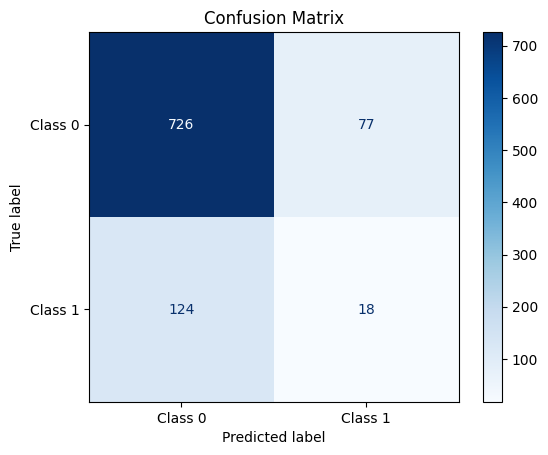

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# 计算混淆矩阵
conf_matrix = confusion_matrix(all_labels, all_predictions)

# 绘制混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [13]:
print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
torch.save(model.state_dict(), 'Simple CNN model.pth')
print("Model saved to Simple CNN model.pth")

Epoch [50/50], Loss: 0.0003, Accuracy: 78.73%
Model saved to Simple CNN model.pth


In [14]:
model.load_state_dict(torch.load('Simple CNN model.pth'))
model.eval()  # 切换到评估模式
print("Model loaded from Simple CNN model.pth")

Model loaded from Simple CNN model.pth


/tmp/ipykernel_7784/711532346.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Simple CNN model.pth'))


In [15]:
test_accuracies

[56.25,
 75.0,
 77.08333333333333,
 78.125,
 73.75,
 71.875,
 75.0,
 76.5625,
 76.38888888888889,
 76.25,
 75.0,
 75.52083333333333,
 75.48076923076923,
 75.44642857142857,
 75.41666666666667,
 76.953125,
 76.83823529411765,
 77.43055555555556,
 77.63157894736842,
 77.8125,
 77.97619047619048,
 78.125,
 78.80434782608695,
 79.16666666666667,
 79.25,
 78.84615384615384,
 78.93518518518519,
 79.24107142857143,
 78.87931034482759,
 78.33333333333333,
 78.4274193548387,
 78.7109375,
 78.59848484848484,
 78.86029411764706,
 78.57142857142857,
 78.64583333333333,
 78.71621621621621,
 78.94736842105263,
 79.16666666666667,
 79.21875,
 79.26829268292683,
 79.16666666666667,
 79.50581395348837,
 79.26136363636364,
 79.30555555555556,
 79.34782608695652,
 79.25531914893617,
 78.90625,
 78.4438775510204,
 78.5,
 78.30882352941177,
 78.48557692307692,
 78.41981132075472,
 78.47222222222223,
 78.63636363636364,
 78.57142857142857,
 78.61842105263158,
 78.77155172413794,
 78.70762711864407,
 78.7301

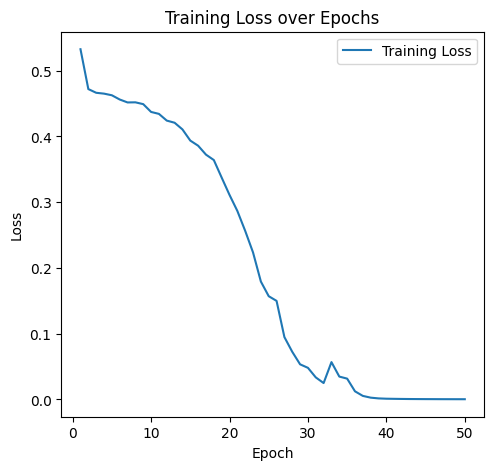

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

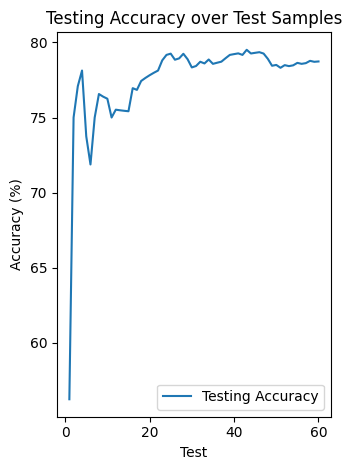

In [23]:
plt.subplot(1, 2, 2)
plt.plot(range(1, 61), test_accuracies, label='Testing Accuracy')
plt.xlabel('Test')
plt.ylabel('Accuracy (%)')
plt.title('Testing Accuracy over Test Samples')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# image_dataset = TensorDataset(image_tensor, y)
# image_dataset_loader = DataLoader(image_dataset, batch_size=16, shuffle=True)

features = eva_data.drop(columns=['is_melanoma']).values  # 提取特征
labels = eva_data['is_melanoma'].values  # 提取标签（如果有）

image_tensor = torch.tensor(image_tensor) if not isinstance(image_tensor, torch.Tensor) else image_tensor
y = torch.tensor(y) if not isinstance(y, torch.Tensor) else y

# 创建 DataLoader，用于批量处理整个数据集
batch_size = 32  # 设置批量大小
eva_loader = DataLoader(TensorDataset(image_tensor, y), batch_size=batch_size, shuffle=False)

# 加载模型并切换到评估模式
model.load_state_dict(torch.load('Simple CNN model.pth'))
model.eval()

# 存储预测结果
predicted_results = []

with torch.no_grad():
    for features_batch, _ in eva_loader:
        outputs = model(features_batch)  # 模型预测
        predicted = (outputs.view(-1) > 0.5).float()  # 二分类，转为 0 或 1
        predicted_results.extend(predicted.cpu().numpy())  # 保存预测结果

# 将预测结果转为 Pandas DataFrame
eva_data['Predicted_Feature'] = predicted_results  # 添加预测结果为新特征

# 打印数据集以检查结果
print(eva_data.head())

/tmp/ipykernel_7784/677693849.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Simple CNN model.pth'))


   age_approx  anatom_site_general  clin_size_long_diam_mm  sex  is_melanoma  \
0    0.913505                    0               -0.535270    0            1   
1   -0.889084                    0               -0.535270    0            0   
2   -0.889084                    2               -0.756603    0            0   
3   -0.588653                    0               -0.313937    1            0   
4   -0.288221                    4               -0.756603    0            0   

   Predicted_Feature  
0                1.0  
1                0.0  
2                0.0  
3                0.0  
4                0.0  


In [25]:
eva_data

,age_approx,anatom_site_general,clin_size_long_diam_mm,sex,is_melanoma,Predicted_Feature
0,0.913505,0,-0.535270,0,1,1.0
1,-0.889084,0,-0.535270,0,0,0.0
2,-0.889084,2,-0.756603,0,0,0.0
3,-0.588653,0,-0.313937,1,0,0.0
4,-0.288221,4,-0.756603,0,0,0.0
...,...,...,...,...,...,...
4719,0.613074,1,1.253099,0,1,1.0
4720,0.613074,0,0.104382,0,0,0.0
4721,-0.588653,0,1.485498,1,0,0.0
4722,-0.288221,3,0.150861,1,0,0.0


In [26]:
eva_data.to_csv('./CNN_data.csv', index=False)

In [36]:
%pip install catboost
%pip install xgboost
%pip install seaborn
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [30]:
X = eva_data.drop(columns=['is_melanoma'])
y = eva_data['is_melanoma']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


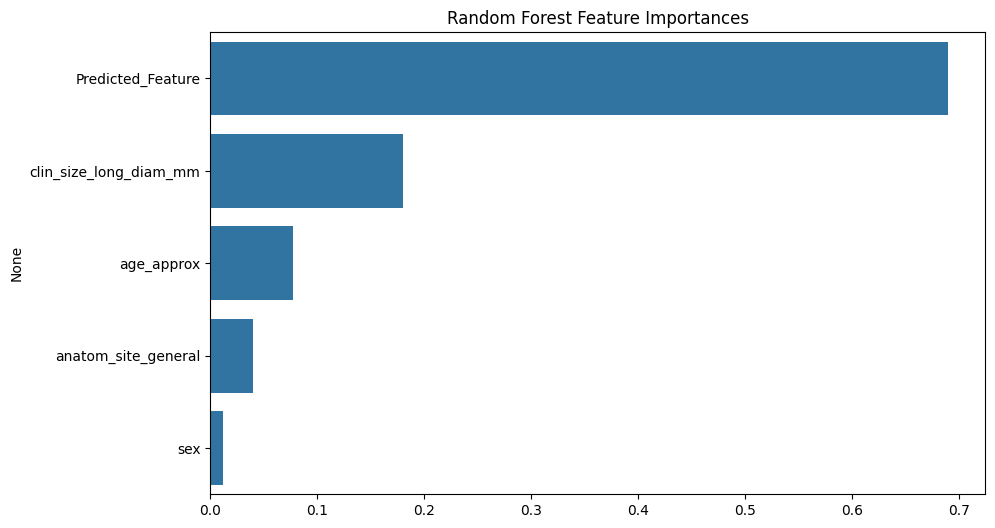

In [33]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# 提取特征重要性
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# 可视化特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Random Forest Feature Importances')
plt.show()


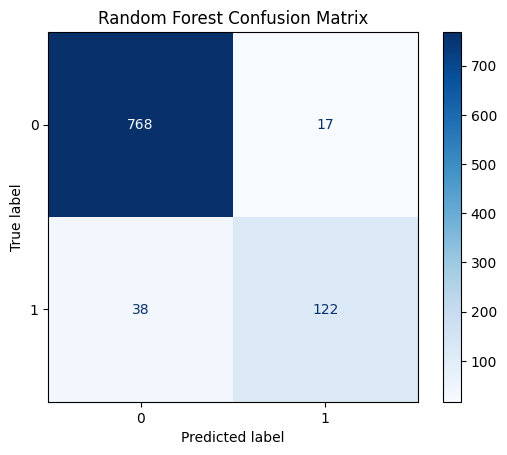

In [34]:
from sklearn.metrics import ConfusionMatrixDisplay

rf_preds = rf.predict(X_test)
cm = confusion_matrix(y_test, rf_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Random Forest Confusion Matrix')
plt.show()


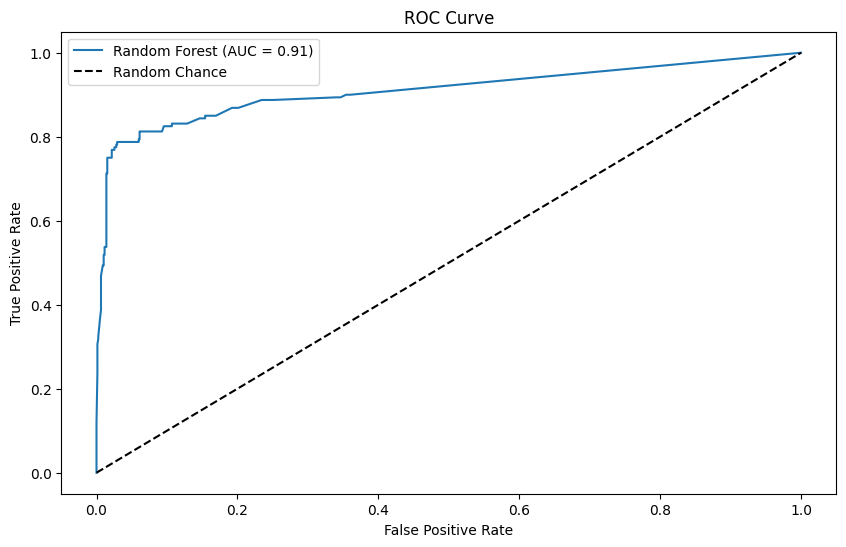

In [37]:
from sklearn.metrics import roc_curve, auc
rf_probs = rf.predict_proba(X_test)[:, 1]  # 获取概率
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [38]:
rf_preds = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))

Random Forest Accuracy: 0.9417989417989417


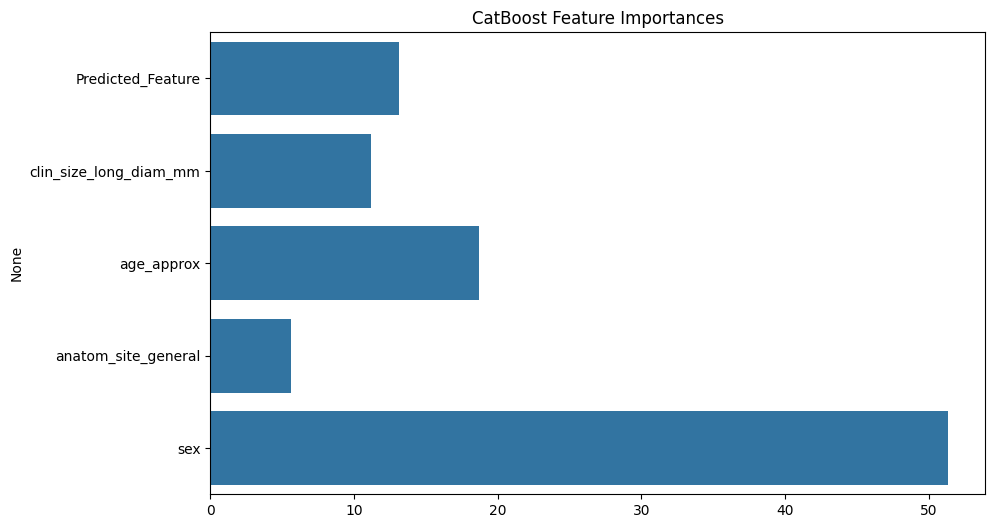

In [39]:
catboost = CatBoostClassifier(verbose=0, random_state=42)
catboost.fit(X_train, y_train)

# 提取特征重要性
cat_importances = catboost.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=cat_importances, y=features[indices])
plt.title('CatBoost Feature Importances')
plt.show()


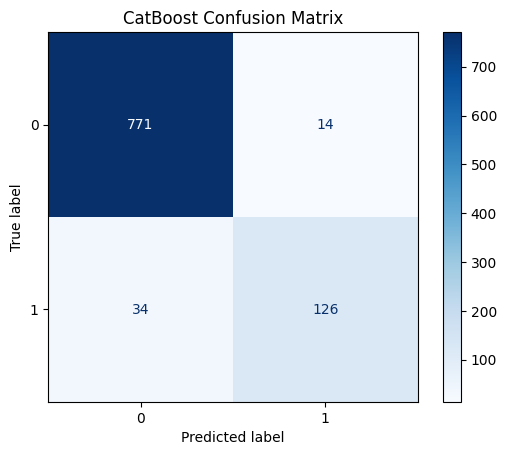

In [40]:
catboost_preds = catboost.predict(X_test)
cm = confusion_matrix(y_test, catboost_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=catboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('CatBoost Confusion Matrix')
plt.show()


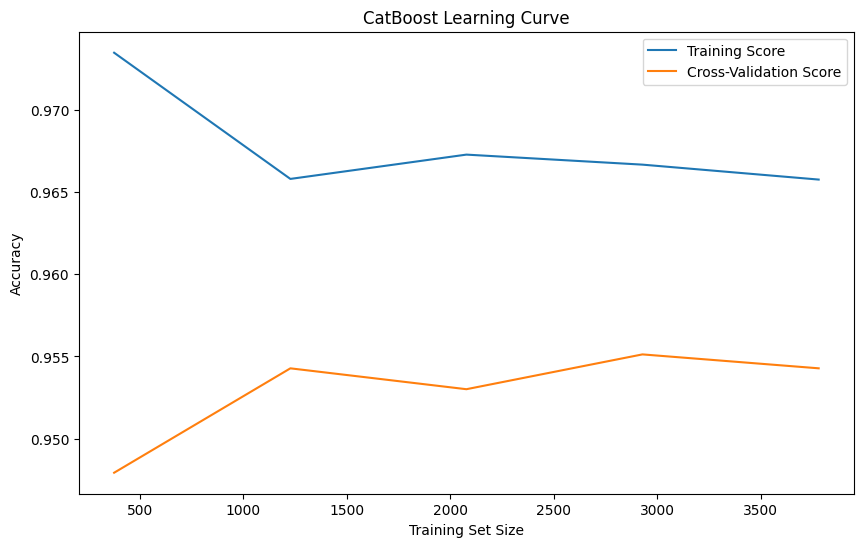

In [42]:
train_sizes, train_scores, test_scores = learning_curve(catboost, X, y, cv=5, scoring='accuracy')

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('CatBoost Learning Curve')
plt.legend()
plt.show()


In [43]:
catboost_preds = catboost.predict(X_test)
print("CatBoost Accuracy:", accuracy_score(y_test, catboost_preds))

CatBoost Accuracy: 0.9492063492063492


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [03:25:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


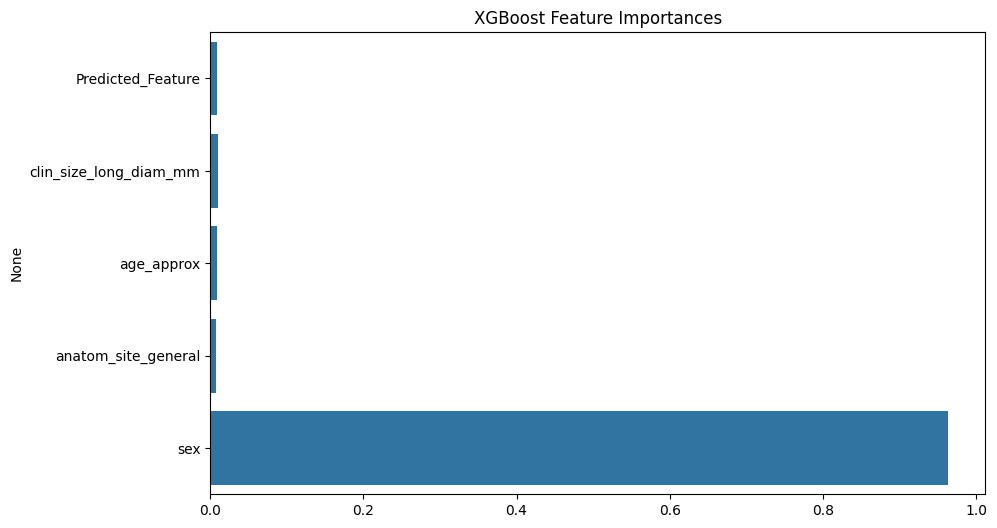

In [44]:
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgboost.fit(X_train, y_train)

# 获取特征重要性
xgb_importances = xgboost.feature_importances_

plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_importances, y=features[indices])
plt.title('XGBoost Feature Importances')
plt.show()


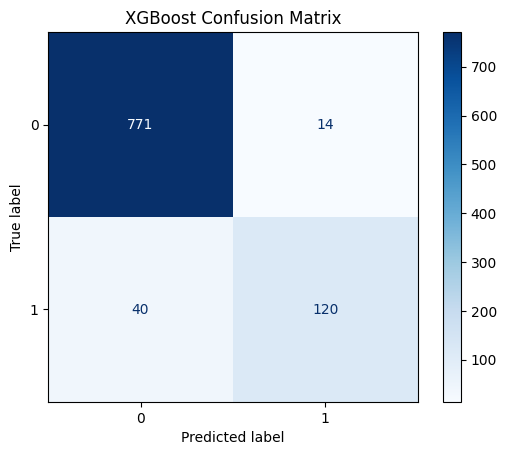

In [45]:
xgboost_preds = xgboost.predict(X_test)
cm = confusion_matrix(y_test, xgboost_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('XGBoost Confusion Matrix')
plt.show()


In [46]:
xgboost_preds = xgboost.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, xgboost_preds))

XGBoost Accuracy: 0.9428571428571428


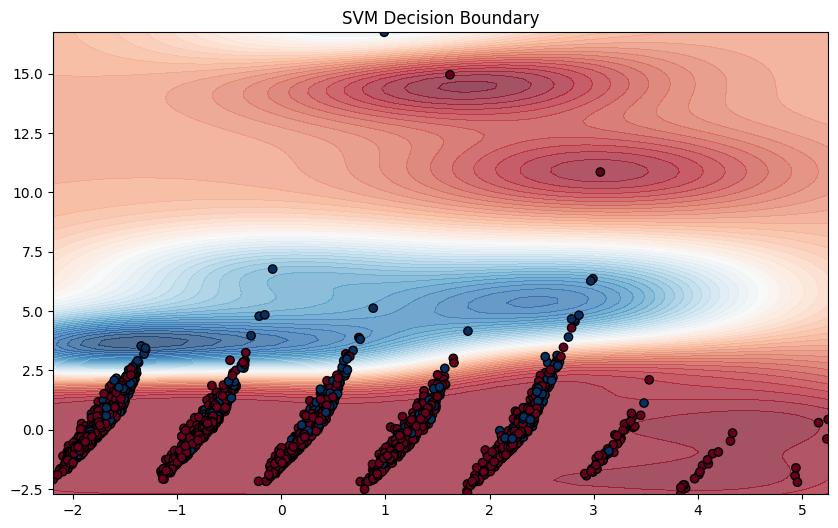

In [47]:
from sklearn.decomposition import PCA

# 使用 PCA 将特征降到 2 维
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

svm = SVC(probability=True, random_state=42)
svm.fit(X_train_pca, y_train)

# 决策边界
xx, yy = np.meshgrid(np.linspace(X_train_pca[:, 0].min(), X_train_pca[:, 0].max(), 100),
                     np.linspace(X_train_pca[:, 1].min(), X_train_pca[:, 1].max(), 100))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, levels=50, cmap="RdBu", alpha=0.7)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolors='k', cmap="RdBu")
plt.title('SVM Decision Boundary')
plt.show()


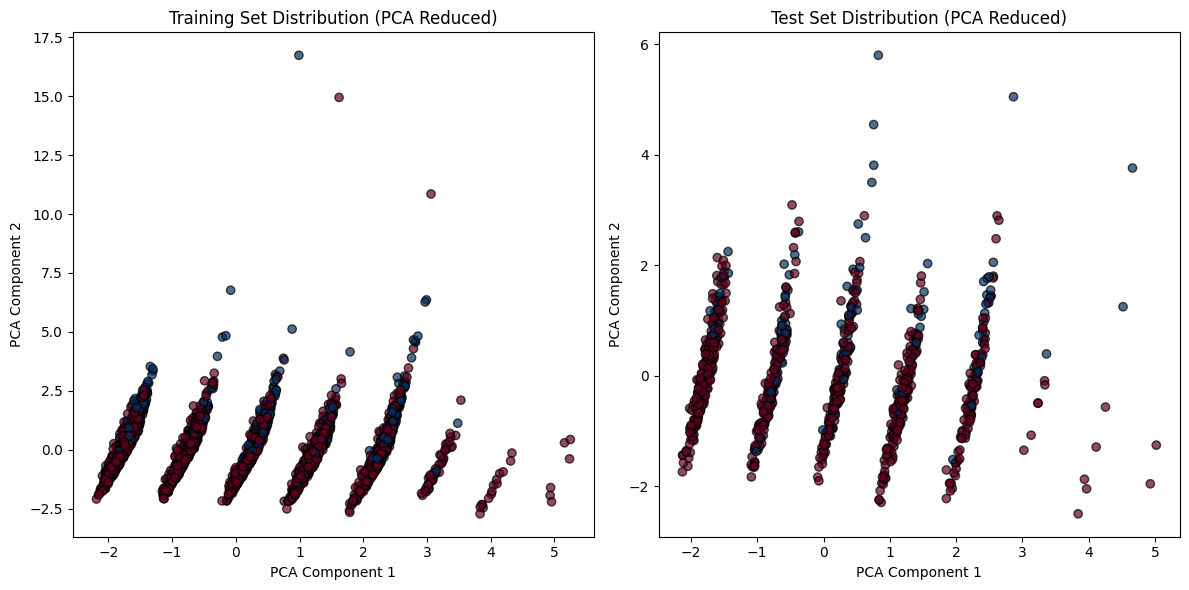

In [53]:
# 绘制训练集与测试集的分布
plt.figure(figsize=(12, 6))

# 训练集分布
plt.subplot(1, 2, 1)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap="RdBu", edgecolors='k', alpha=0.7)
plt.title("Training Set Distribution (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# 测试集分布
plt.subplot(1, 2, 2)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap="RdBu", edgecolors='k', alpha=0.7)
plt.title("Test Set Distribution (PCA Reduced)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

plt.tight_layout()
plt.show()


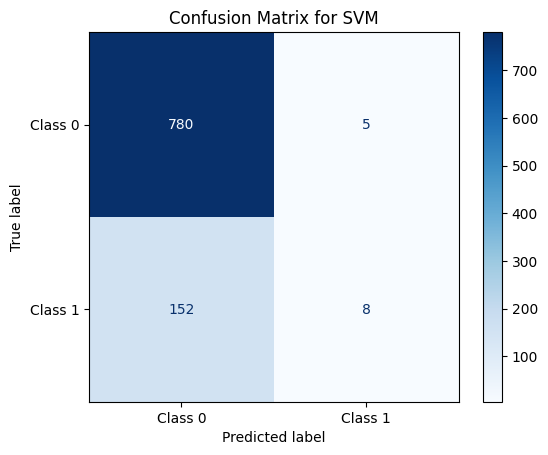

In [56]:
# 获取预测结果
y_pred = svm.predict(X_test_pca)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 创建混淆矩阵的可视化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# 绘制混淆矩阵
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 使用蓝色调并显示为整数
plt.title('Confusion Matrix for SVM')
plt.show()

In [57]:
svm_preds = svm.predict(X_test_pca)
print("SVM Accuracy:", accuracy_score(y_test, svm_preds))

SVM Accuracy: 0.8338624338624339


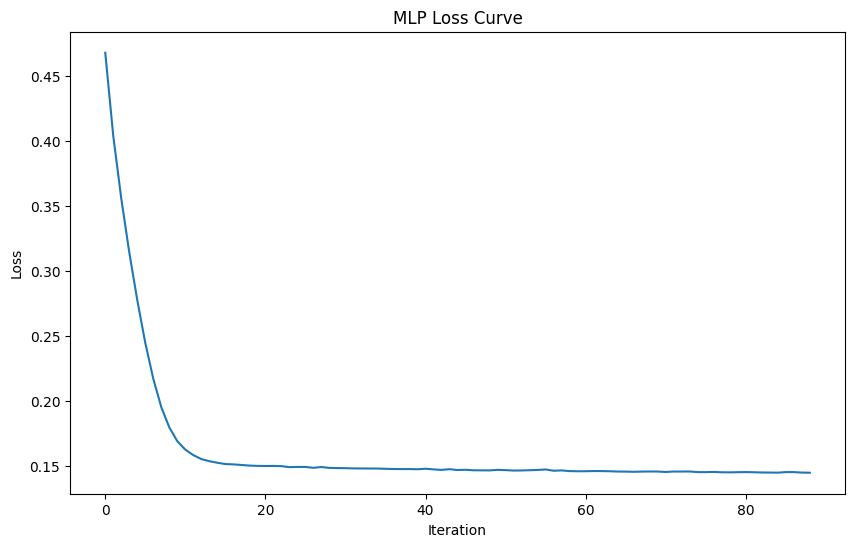

In [50]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plt.plot(mlp.loss_curve_)
plt.title('MLP Loss Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()


In [51]:
mlp_preds = mlp.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_preds))

MLP Accuracy: 0.9502645502645503


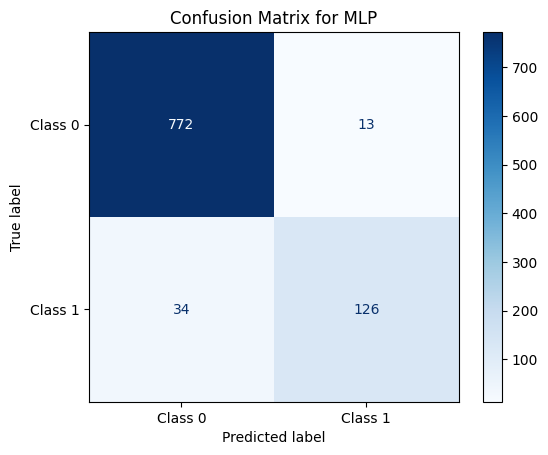

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 获取预测结果
y_pred = mlp.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 创建混淆矩阵的可视化
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

# 绘制混淆矩阵
disp.plot(cmap=plt.cm.Blues, values_format='d')  # 使用蓝色调并显示为整数
plt.title('Confusion Matrix for MLP')
plt.show()


/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptro

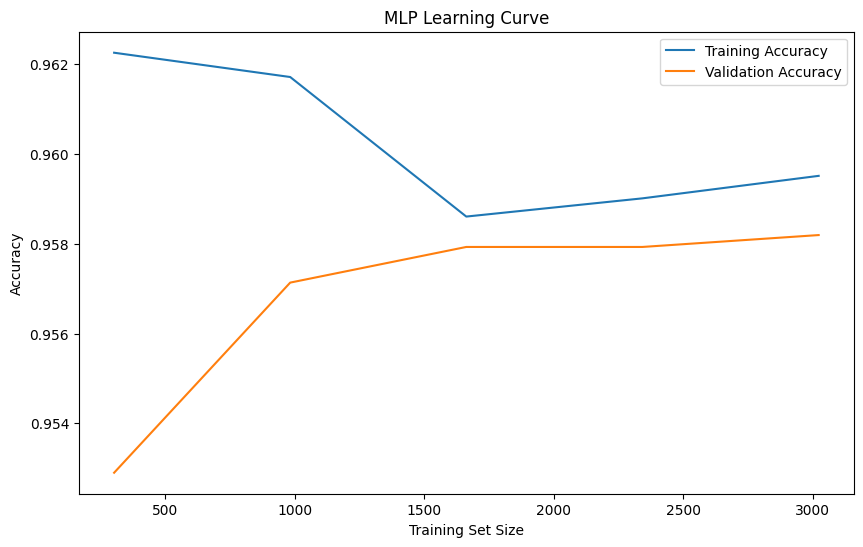

In [59]:
from sklearn.model_selection import learning_curve

# 获取学习曲线数据
train_sizes, train_scores, valid_scores = learning_curve(mlp, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# 计算平均分数
train_mean = train_scores.mean(axis=1)
valid_mean = valid_scores.mean(axis=1)

# 绘制学习曲线
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.plot(train_sizes, valid_mean, label='Validation Accuracy')
plt.title('MLP Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


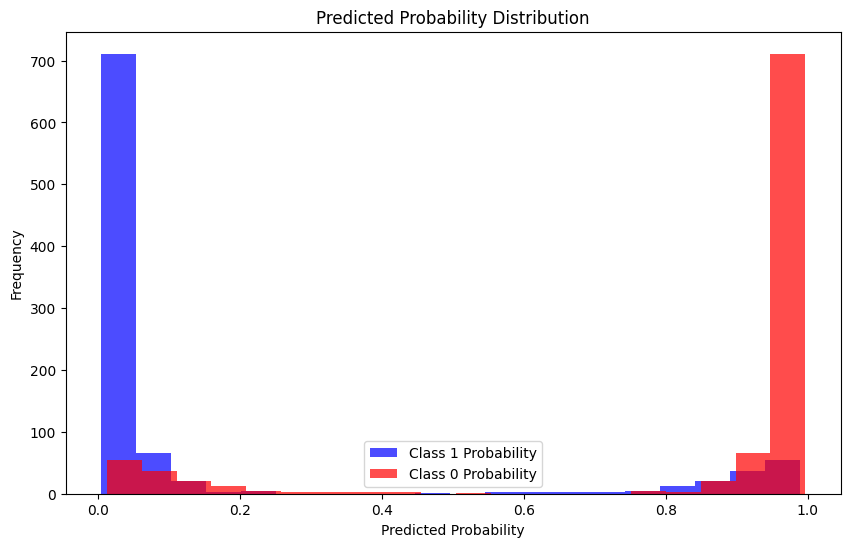

In [60]:
# 获取模型对测试集的预测概率
y_proba = mlp.predict_proba(X_test)

# 绘制预测概率的分布
plt.figure(figsize=(10, 6))
plt.hist(y_proba[:, 1], bins=20, alpha=0.7, color='blue', label='Class 1 Probability')
plt.hist(y_proba[:, 0], bins=20, alpha=0.7, color='red', label='Class 0 Probability')
plt.title('Predicted Probability Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()
